In [ ]:
%pip install peft accelerate loralib

In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from datasets import Dataset
from peft import PeftConfig, PeftModel
from torch import nn
from torch.utils.data import TensorDataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    integrations,
)


In [34]:
base_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(base_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(base_name)

full_dataset = Dataset.from_text("spam_messages_names.txt")
full_dataset = full_dataset.map(
    lambda example: tokenizer(example["text"]), batched=True
)
data_dict = full_dataset.train_test_split(test_size=0.01, shuffle=True, seed=42)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Using custom data configuration default-c026a0da68931db6
Found cached dataset text (/home/mike/.cache/huggingface/datasets/text/default-c026a0da68931db6/0.0.0)
Loading cached processed dataset at /home/mike/.cache/huggingface/datasets/text/default-c026a0da68931db6/0.0.0/cache-4c558e740f1d48fa.arrow


61057 617
{'text': 'Sōl Astrī: Не похоже', 'input_ids': [55, 134, 240, 80, 49062, 86, 133, 109, 30, 832, 5175], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
430


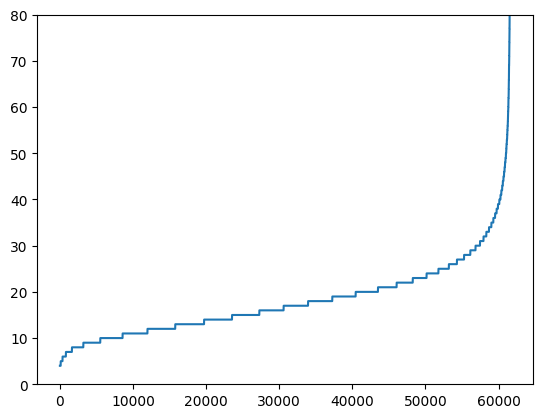

In [35]:
print(len(data_dict["train"]), len(data_dict["test"]))
print(full_dataset[-1])
lengths = np.array(sorted([len(elem["input_ids"]) for elem in full_dataset]))
print(lengths[-1])

plt.plot(lengths)
plt.ylim(0, 80)
plt.show()

In [32]:
for param in model.parameters():
    param.requires_grad = False  # freeze the model - train adapters later
    if param.ndim == 1:
        # cast the small parameters (e.g. layernorm) to fp32 for stability
        param.data = param.data.to(torch.float32)

model.gradient_checkpointing_enable()  # reduce number of stored activations


class CastOutputToFloat(nn.Sequential):
    def forward(self, x):
        return super().forward(x).to(torch.float32)


model.lm_head = CastOutputToFloat(model.lm_head)


In [33]:
from peft import LoraConfig, get_peft_model


def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable: {100 * trainable_params / all_param:.2f}%"
    )


config = LoraConfig(
    r=16,  # attention heads
    lora_alpha=32,  # alpha scaling
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",  # set this for CLM or Seq2Seq
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


/home/mike/.local/lib/python3.10/site-packages/peft/tuners/lora.py:240: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 589824 || all params: 125821440 || trainable: 0.47%


In [68]:
training_args = TrainingArguments(
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=100,
    max_steps=200,
    learning_rate=2e-4,
    logging_steps=1,
    output_dir="outputs",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
)

trainer = Trainer(
    model,
    train_dataset=data_dict["train"],
    eval_dataset=data_dict["test"],
    args=training_args,
    tokenizer=tokenizer,
    data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False),
)


PyTorch: setting up devices
max_steps is given, it will override any value given in num_train_epochs


In [39]:
results_before = trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 617
  Batch size = 8
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/78 [00:00<?, ?it/s]

In [66]:
print(results_before)
for prompt in ["a ", "Mikhail Budnikov:", "Rodion Khvorostov:", "Veronika Sirotkina:"]:
    print("Results for", prompt)
    for it in range(10):
        tokens = tokenizer(prompt, return_tensors="pt")
        g = model.generate(**tokens, max_new_tokens=20, pad_token_id=50256, return_dict_in_generate=True, do_sample=True)
        prediction = g.sequences[0]
        print(tokenizer.decode(prediction))

{'eval_loss': 5.105103492736816, 'eval_runtime': 31.114, 'eval_samples_per_second': 19.83, 'eval_steps_per_second': 2.507}
Results for a 
a  


13410664	evstoliya-3	2018-01-
a  - http://specialtyaz.ru...✂ 
 [url=http://spec
a  
		И всё идёт как надо. 
		А всё идёт, как по плану.
a ugly" for me

The Wizards of the Witcher 3 (1937
a  &amp;lt;!-- IRE.END, SHEARER.
a ubereait, poderia pacera, et los datos
a é traviada e melhor seja é, comentário p
a },      {1},      {2},      {3},
a echo \[################
a ua, pelicanos ou fácil, do eu sacriir
Results for Mikhail Budnikov:
Mikhail Budnikov: "Cross-continental" - это только мое субъективное мнение. И я искренне не
Mikhail Budnikov: The new #ModulationBridge can be called a model for “Portal” techn
Mikhail Budnikov: "Все что сегодня происходит в нашей стране сегодня, в том числе наши действия, – это отражение нашей
Mikhail Budnikov: «Полукоммерческая недвижимость в г. Москве», Москва, «Территория недвижимости и
Mikhail Budnikov: Что значи

In [69]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
/home/mike/.local/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 61057
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 200
  Number of trainable parameters = 125231616


  0%|          | 0/200 [00:00<?, ?it/s]

{'loss': 5.2611, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.0}
{'loss': 5.2101, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.0}
{'loss': 5.4502, 'learning_rate': 6e-06, 'epoch': 0.0}
{'loss': 4.8848, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.0}
{'loss': 5.2576, 'learning_rate': 1e-05, 'epoch': 0.0}
{'loss': 4.8429, 'learning_rate': 1.2e-05, 'epoch': 0.0}
{'loss': 4.674, 'learning_rate': 1.4000000000000001e-05, 'epoch': 0.0}
{'loss': 4.761, 'learning_rate': 1.6000000000000003e-05, 'epoch': 0.0}
{'loss': 4.7102, 'learning_rate': 1.8e-05, 'epoch': 0.0}
{'loss': 4.352, 'learning_rate': 2e-05, 'epoch': 0.0}
{'loss': 3.7165, 'learning_rate': 2.2000000000000003e-05, 'epoch': 0.0}
{'loss': 4.0495, 'learning_rate': 2.4e-05, 'epoch': 0.0}
{'loss': 3.8335, 'learning_rate': 2.6000000000000002e-05, 'epoch': 0.0}
{'loss': 3.9267, 'learning_rate': 2.8000000000000003e-05, 'epoch': 0.0}
{'loss': 3.6018, 'learning_rate': 3e-05, 'epoch': 0.0}
{'loss': 3.8515, 'learning_rate': 3.20

The following columns in the evaluation set don't have a corresponding argument in `GPT2LMHeadModel.forward` and have been ignored: text. If text are not expected by `GPT2LMHeadModel.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 617
  Batch size = 8


{'loss': 2.1579, 'learning_rate': 0.0, 'epoch': 0.05}


  0%|          | 0/78 [00:00<?, ?it/s]

Saving model checkpoint to outputs/checkpoint-200
Configuration saved in outputs/checkpoint-200/config.json


{'eval_loss': 2.6826398372650146, 'eval_runtime': 39.8075, 'eval_samples_per_second': 15.5, 'eval_steps_per_second': 1.959, 'epoch': 0.05}


Model weights saved in outputs/checkpoint-200/pytorch_model.bin
tokenizer config file saved in outputs/checkpoint-200/tokenizer_config.json
Special tokens file saved in outputs/checkpoint-200/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from outputs/checkpoint-200 (score: 2.6826398372650146).


{'train_runtime': 754.6302, 'train_samples_per_second': 4.24, 'train_steps_per_second': 0.265, 'train_loss': 3.0358620142936705, 'epoch': 0.05}


TrainOutput(global_step=200, training_loss=3.0358620142936705, metrics={'train_runtime': 754.6302, 'train_samples_per_second': 4.24, 'train_steps_per_second': 0.265, 'train_loss': 3.0358620142936705, 'epoch': 0.05})

In [ ]:
model.save_pretrained("short_messages") # or model.push_to_hub

In [ ]:
peft_model_id = "short_messages"
config = PeftConfig.from_pretrained(peft_model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(base_name)
model = PeftModel.from_pretrained(model, peft_model_id)
tokenizer = AutoTokenizer.from_pretrained(base_name)

model = model.to(device)
model.eval()
inputs = tokenizer("Tweet text : @HondaCustSvc Your customer service has been horrible during the recall process. I will never purchase a Honda again. Label :", return_tensors="pt")

with torch.no_grad():
    outputs = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_new_tokens=10)
    print(tokenizer.batch_decode(outputs.detach().cpu().numpy(), skip_special_tokens=True)[0])
# 'complaint'